# Lesson 4: Tool Use and Conversational Chess

## Setup

In [1]:
llm_config = {"model": "gpt-4-turbo"}

In [2]:
import chess
import chess.svg
from typing_extensions import Annotated

## Initialize the chess board

In [3]:
board = chess.Board()

In [4]:
made_move = False

## Define the needed tools

### 1. Tool for getting legal moves

In [5]:
def get_legal_moves(
    
) -> Annotated[str, "A list of legal moves in UCI format"]:
    return "Possible moves are: " + ",".join(
        [str(move) for move in board.legal_moves]
    )

### 2. Tool for making a move on the board

In [6]:
def make_move(
    move: Annotated[str, "A move in UCI format."]
) -> Annotated[str, "Result of the move."]:
    move = chess.Move.from_uci(move)
    board.push_uci(str(move))
    global made_move
    made_move = True
    
    # Display the board.
    display(
        chess.svg.board(
            board,
            arrows=[(move.from_square, move.to_square)],
            fill={move.from_square: "gray"},
            size=200
        )
    )
    
    # Get the piece name.
    piece = board.piece_at(move.to_square)
    piece_symbol = piece.unicode_symbol()
    piece_name = (
        chess.piece_name(piece.piece_type).capitalize()
        if piece_symbol.isupper()
        else chess.piece_name(piece.piece_type)
    )
    return f"Moved {piece_name} ({piece_symbol}) from "\
    f"{chess.SQUARE_NAMES[move.from_square]} to "\
    f"{chess.SQUARE_NAMES[move.to_square]}."

## Create agents

You will create the player agents and a board proxy agents for the chess board.

In [7]:
from autogen import ConversableAgent

In [8]:
# Player white agent
player_white = ConversableAgent(
    name="Player White",
    system_message="You are a chess player and you play as white. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config=llm_config,
)

In [9]:
# Player black agent
player_black = ConversableAgent(
    name="Player Black",
    system_message="You are a chess player and you play as black. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config=llm_config,
)

In [10]:
def check_made_move(msg):
    global made_move
    if made_move:
        made_move = False
        return True
    else:
        return False


In [11]:
board_proxy = ConversableAgent(
    name="Board Proxy",
    llm_config=False,
    is_termination_msg=check_made_move,
    default_auto_reply="Please make a move.",
    human_input_mode="NEVER",
)

## Register the tools

A tool must be registered for the agent that calls the tool and the agent that executes the tool.

In [12]:
from autogen import register_function

In [13]:
for caller in [player_white, player_black]:
    register_function(
        get_legal_moves,
        caller=caller,
        executor=board_proxy,
        name="get_legal_moves",
        description="Get legal moves.",
    )
    
    register_function(
        make_move,
        caller=caller,
        executor=board_proxy,
        name="make_move",
        description="Call this tool to make a move.",
    )

In [14]:
player_black.llm_config["tools"]

[{'type': 'function',
  'function': {'description': 'Get legal moves.',
   'name': 'get_legal_moves',
   'parameters': {'type': 'object', 'properties': {}, 'required': []}}},
 {'type': 'function',
  'function': {'description': 'Call this tool to make a move.',
   'name': 'make_move',
   'parameters': {'type': 'object',
    'properties': {'move': {'type': 'string',
      'description': 'A move in UCI format.'}},
    'required': ['move']}}}]

## Register the nested chats

Each player agent will have a nested chat with the board proxy agent to
make moves on the chess board.

In [15]:
player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
            "summary_method": "last_msg",
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
            "summary_method": "last_msg",
        }
    ],
)

## Start the Game

The game will start with the first message.

<p style="background-color:#ECECEC; padding:15px; "> <b>Note:</b> In this lesson, you will use GPT 4 for better results. Please note that the lesson has a quota limit. If you want to explore the code in this lesson further, we recommend trying it locally with your own API key.

**Note**: You might get a slightly different moves than what's shown in the video.

Player Black (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

***** Suggested tool call (call_vo3HMkMzafT2ew1hTtLSNGVz): get_legal_moves *****
Arguments: 
{}
********************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION get_legal_moves...
Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_vo3HMkMzafT2ew1hTtLSNGV

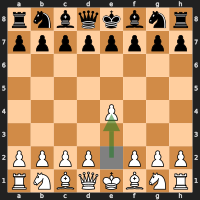

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_rSTSLYb3mRM5BqOC8VeUnXH0) *****
Moved pawn (♙) from e2 to e4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've made my move: pawn from e2 to e4. Your turn!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've made my move: pawn from e2 to e4. Your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've made my move: pawn from e2 to e4. Your turn!

----------------------

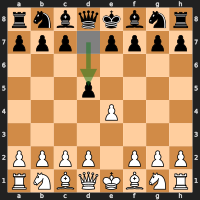

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_m5yizDy26BSrjg0rC1Zn9EG1) *****
Moved pawn (♟) from d7 to d5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my pawn from d7 to d5. Your turn!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my pawn from d7 to d5. Your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved my pawn from d7 to d5. Your turn!

-------------------------------------

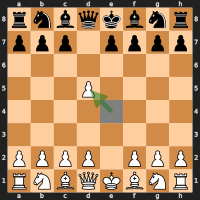

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_uVUmIWbirjDrFOWzfGjnu0yE) *****
Moved pawn (♙) from e4 to d5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my pawn from e4 to d5. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my pawn from e4 to d5. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my pawn from e4 to d5. Your move!

-------------------------------------

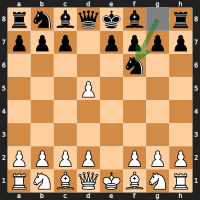

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_6SXI6jU1tf8wwGMqY37SjuyZ) *****
Moved knight (♞) from g8 to f6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my knight from g8 to f6. Your move!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my knight from g8 to f6. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved my knight from g8 to f6. Your move!

-----------------------------

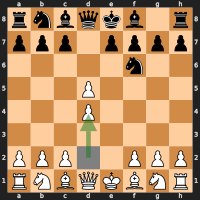

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_y39Ji7KqPPrTcC46ho5QuLRG) *****
Moved pawn (♙) from d2 to d4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my pawn from d2 to d4. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my pawn from d2 to d4. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my pawn from d2 to d4. Your move!

-------------------------------------

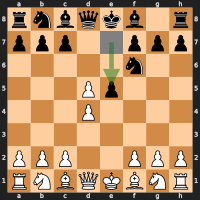

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_w2X3T8z9mNj7mXOnrFIRBj3a) *****
Moved pawn (♟) from e7 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved the pawn from e7 to e5 to challenge the center and enable more piece development. It's your move now!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved the pawn from e7 to e5 to challenge the center and enable more piece development. It's your move now!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

************************************************************

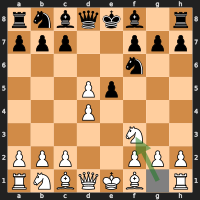

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_NKBzKcPSSR6zYRk8KjnN7r2o) *****
Moved knight (♘) from g1 to f3.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved the knight from g1 to f3, attacking your e5 pawn and developing towards the center. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved the knight from g1 to f3, attacking your e5 pawn and developing towards the center. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

************************************************************************

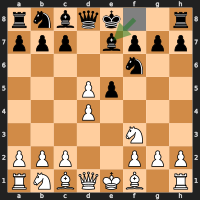

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_B8C8egMm8VIGpfI31okrCTuL) *****
Moved bishop (♝) from f8 to e7.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved the bishop from f8 to e7, developing it to support your central and king-side structure. It's now your turn!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved the bishop from f8 to e7, developing it to support your central and king-side structure. It's now your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************

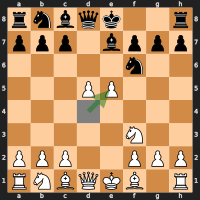

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_YzRptwnydheIa07ZcCbXen1L) *****
Moved pawn (♙) from d4 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved the pawn from d4 to e5 to strengthen our central control and create potential threats. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved the pawn from d4 to e5 to strengthen our central control and create potential threats. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************

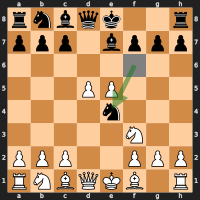

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_oc5WW35bNW8qrkhZUSbtGQbY) *****
Moved knight (♞) from f6 to e4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved the knight from f6 to e4, strengthening our central control and creating threats towards the opponent's position. Your opponent's move is next!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved the knight from f6 to e4, strengthening our central control and creating threats towards the opponent's position. Your opponent's move is next!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************

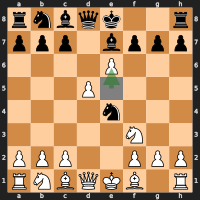

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_KX7vSiAY3qIKirzQP6vBpm0Q) *****
Moved pawn (♙) from e5 to e6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

The pawn has been successfully moved from e5 to e6, aiming to disrupt your opponent's pawn structure and create more opportunities for your other pieces. Your opponent's move is now up next!

--------------------------------------------------------------------------------
Player White (to Player Black):

The pawn has been successfully moved from e5 to e6, aiming to disrupt your opponent's pawn structure and create more opportunities for your other pieces. Your opponent's move is now up next!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

**********

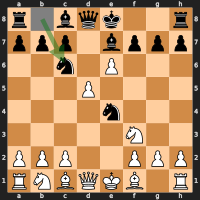

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_8sGjTVaOzUVJSvVfoHSZ7bAY) *****
Moved knight (♞) from b8 to c6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved the knight from b8 to c6. It's now your opponent's turn to move. If you have any strategy in mind or need to examine the board, just let me know!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved the knight from b8 to c6. It's now your opponent's turn to move. If you have any strategy in mind or need to examine the board, just let me know!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

****************************************************************************

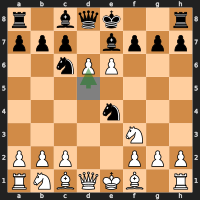

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_fAPFJUb1EDpdyS7GL4P4R1GF) *****
Moved pawn (♙) from d5 to d6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I have moved the pawn from d5 to d6. It's now your opponent's turn. Let me know if you need any more information or assistance with your strategy!

--------------------------------------------------------------------------------
Player White (to Player Black):

I have moved the pawn from d5 to d6. It's now your opponent's turn. Let me know if you need any more information or assistance with your strategy!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new ch

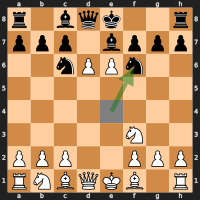

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_NKBzKcPSSR6zYRk8KjnN7r2o) *****
Moved knight (♞) from e4 to f6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

The knight has been successfully moved from e4 to f6. It's now your opponent's turn. Let me know if you need any further assistance or strategy advice!

--------------------------------------------------------------------------------
Player Black (to Player White):

The knight has been successfully moved from e4 to f6. It's now your opponent's turn. Let me know if you need any further assistance or strategy advice!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Start

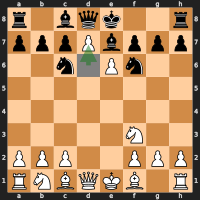

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_pwUZQY1YjP0nJrfUaWjIYKBt) *****
Moved pawn (♙) from d6 to d7.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

The move has been made: the pawn (♙) has been advanced from d6 to d7. It's now the opponent's turn. Let me know when you are ready to continue or if you need any analysis or assistance!

--------------------------------------------------------------------------------
Player White (to Player Black):

The move has been made: the pawn (♙) has been advanced from d6 to d7. It's now the opponent's turn. Let me know when you are ready to continue or if you need any analysis or assistance!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************

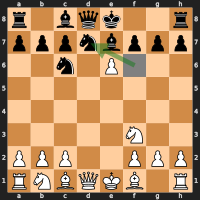

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_Zt5gDBufKL9RRCgKdKCc8KM2) *****
Moved knight (♞) from f6 to d7.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

The knight has been successfully moved from f6 to d7. It's now the opponent's turn. 

Let me know when you are ready to continue, need to see the list of legal moves again, or if there's anything else you'd like assistance with!

--------------------------------------------------------------------------------
Player Black (to Player White):

The knight has been successfully moved from f6 to d7. It's now the opponent's turn. 

Let me know when you are ready to continue, need to see the list of legal moves again, or if there's anything else you'd like assistance with!

--------------------------------------------

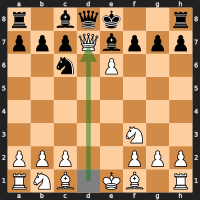

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_KX7vSiAY3qIKirzQP6vBpm0Q) *****
Moved queen (♕) from d1 to d7.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

The queen has been successfully moved from d1 to d7. It's now the opponent's turn.

Let me know when you are ready to continue and if you want to see the legal moves again, or if there's anything else you'd like to do!

--------------------------------------------------------------------------------
Player White (to Player Black):

The queen has been successfully moved from d1 to d7. It's now the opponent's turn.

Let me know when you are ready to continue and if you want to see the legal moves again, or if there's anything else you'd like to do!

-----------------------------------------------------------------

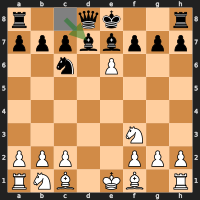

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_q2PZWUtJDOUmoYrJmmRI3CzX) *****
Moved bishop (♝) from c8 to d7.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

The move has been made: Bishop from c8 to d7. It's now the opponent's turn.

Let me know when you are ready to proceed and if you'd like to see the new set of legal moves or anything else!

--------------------------------------------------------------------------------
Player Black (to Player White):

The move has been made: Bishop from c8 to d7. It's now the opponent's turn.

Let me know when you are ready to proceed and if you'd like to see the new set of legal moves or anything else!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

************

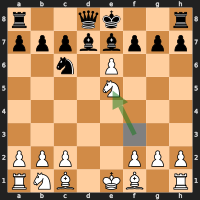

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_koRa0WZEzXFZTk4VySknubDU) *****
Moved knight (♘) from f3 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

The knight move from f3 to e5 has been made. It's now the opponent's turn.

Let me know when you are ready to see the next set of legal moves or if there's anything else you'd like to do!

--------------------------------------------------------------------------------
Player White (to Player Black):

The knight move from f3 to e5 has been made. It's now the opponent's turn.

Let me know when you are ready to see the next set of legal moves or if there's anything else you'd like to do!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

**************

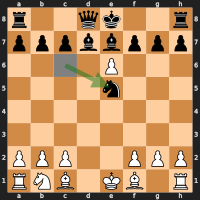

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_dqV0JWr0joMsLg1OEXPcqjKz) *****
Moved knight (♞) from c6 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

The move knight from c6 to e5 has been successfully made. It's now the opponent's turn.

Please let me know when you are ready for the next steps or if there's anything specific you'd like to do next!

--------------------------------------------------------------------------------
Player Black (to Player White):

The move knight from c6 to e5 has been successfully made. It's now the opponent's turn.

Please let me know when you are ready for the next steps or if there's anything specific you'd like to do next!

--------------------------------------------------------------------------------

>>>>>>>> USING AUT

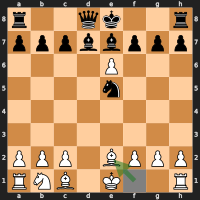

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_tsscRppCNmyXzWbcgzvTdzOz) *****
Moved bishop (♗) from f1 to e2.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

The move has been made: the bishop has moved from f1 to e2. It's now the opponent's turn. 

Let me know when you are ready to continue or if there's anything else you'd like to do!

--------------------------------------------------------------------------------
Player White (to Player Black):

The move has been made: the bishop has moved from f1 to e2. It's now the opponent's turn. 

Let me know when you are ready to continue or if there's anything else you'd like to do!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

****************************

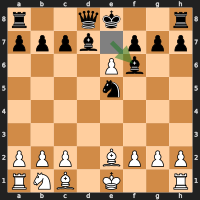

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_pP1K7kIzq96GdQ1btgJfUTzi) *****
Moved bishop (♝) from e7 to f6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

The move has been made: the bishop has moved from e7 to f6.

Your position on the board is strengthening, with the bishop now actively participating in both defense and potential attacks. Let me know if there's anything else you'd like to do or when you're ready to continue after the opponent's move!

--------------------------------------------------------------------------------
Player Black (to Player White):

The move has been made: the bishop has moved from e7 to f6.

Your position on the board is strengthening, with the bishop now actively participating in both defense and potential attacks. Let me know i

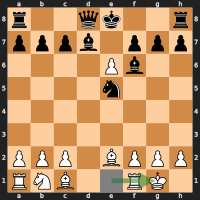

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_gzhvFkq5MmyY2o5RJyRYKBIa) *****
Moved king (♔) from e1 to g1.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

The move has been made: the king has castled kingside, moving from e1 to g1. This strategic move enhances the safety of your king by tucking it away from the center.

Let me know if there's anything else you want to do or when you'd like to proceed after the opponent's move!

--------------------------------------------------------------------------------
Player White (to Player Black):

The move has been made: the king has castled kingside, moving from e1 to g1. This strategic move enhances the safety of your king by tucking it away from the center.

Let me know if there's anything else you want to do or when yo

In [ ]:
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="Let's play chess! Your move.",
    max_turns=1000,
)

## Adding a fun chitchat to the game!

In [ ]:
player_white = ConversableAgent(
    name="Player White",
    system_message="You are a chess player and you play as white. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move. "
    "After a move is made, chitchat to make the game fun.",
    llm_config=llm_config,
)

In [ ]:
player_black = ConversableAgent(
    name="Player Black",
    system_message="You are a chess player and you play as black. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move. "
    "After a move is made, chitchat to make the game fun.",
    llm_config=llm_config,
)

In [ ]:
for caller in [player_white, player_black]:
    register_function(
        get_legal_moves,
        caller=caller,
        executor=board_proxy,
        name="get_legal_moves",
        description="Get legal moves.",
    )

    register_function(
        make_move,
        caller=caller,
        executor=board_proxy,
        name="make_move",
        description="Call this tool to make a move.",
    )

player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
            "summary_method": "last_msg",
            "silent": True,
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
            "summary_method": "last_msg",
            "silent": True,
        }
    ],
)

In [ ]:
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="Let's play chess! Your move.",
    max_turns=2,
)

**Note:** 
To add human input to this game, add **human_input_mode="ALWAYS"** for both player agents.